In [823]:
# Import libraries

import pywt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import statsmodels.formula.api as smf

In [824]:
# Load data
df = pd.read_csv('SMDG_results.csv')

# Randomly shuffle data
df = df.sample(frac=1, ignore_index=True)

# Remove rows with missing values
df = df.dropna()

# Remove rows where glaucoma is not 0 or 1
# df = df[df['glaucoma'].isin([0, 1])]

# Remove unnecesary columns
# keep = ['filename', 'glaucoma'] + [col for col in df.columns if 'pcdr_' in col]
delta_ang = 5
keep = ['filename', 'glaucoma'] + ['pcdr_' + str(i) for i in range(0, 360, delta_ang)]
df = df[keep]

# Keep pcdr_ columns every 2
# df = df.iloc[:, [0, 1] + list(range(2, df.shape[1], 2))]

# Remove rows with 'glaucoma' equal to -1
df = df[df['glaucoma'] != -1]

# Keep only rows with filename starting with 'ORIGA'
# df = df[df['filename'].str.startswith('ORIGA')]

# Cap pcdr_ values to 1
# df[df.iloc[:, 2:] > 1] = 1

# Keep only rows that have pcdr_ values (lb, ub]
lb = 0 ; ub = 1
df = df[(df.iloc[:, 2:] <= lb).any(axis=1).__invert__() & (df.iloc[:, 2:] > ub).any(axis=1).__invert__()]

# Remove rows with all pcdr_ values equal to 1
df = df[(df.iloc[:, 2:] == 1).all(axis=1).__invert__()]

# Split data into train and test
seed = np.random.randint(0, 10000)
np.random.seed(seed)
train = df.sample(frac=0.7)
test = df.drop(train.index)
print('Train:', train.shape[0])
print('Test:', test.shape[0])
print('#############################################')
print('Images suitable for analysis:', df.shape[0])
print('Glaucoma:', (df['glaucoma'] == 1).sum())
print('Non glaucoma:', (df['glaucoma'] == 0).sum())
print('Glaucoma-suspect:', (df['glaucoma'] == -1).sum())

Train: 5310
Test: 2276
#############################################
Images suitable for analysis: 7586
Glaucoma: 2747
Non glaucoma: 4839
Glaucoma-suspect: 0


**Disclaimer**

- Disc, cup and fovea segmentations are done using segmentation CNNs. Very useful for large batches of data but can generate some weird segmentations, especially in low quality fundus images.

**Excluding rules**

- All pCDR values == 1: ellipses fitted to cup and disc segmentations are equal or almost equal.
  
- pCDR values very low: generally caused by the disc segmentation not being great (disc surrounding tissue, pathology near disc, disc edge barely visible...).
  
- pCDR values > 1: disc and cup ellipses are very very close together and, mathematically, the calculation of the intersection points leads to the cup_points going over the disc_points.

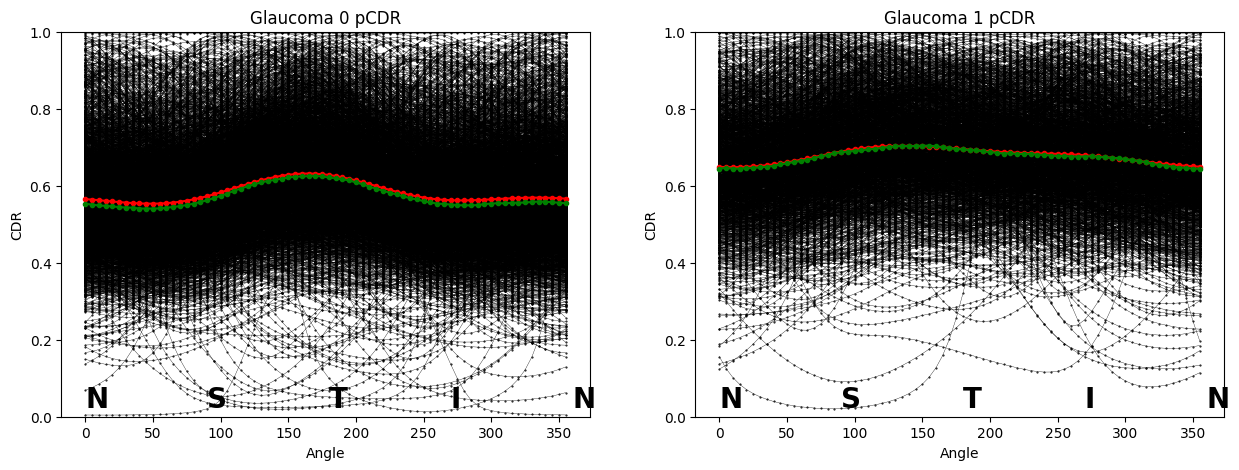

In [912]:
# Group by glaucoma status
df_grouped = train.groupby('glaucoma')

# Plot pcdr values
plt.figure(figsize=(15, 5))
# Number of groups to plot
n_groups = len(df_grouped)
for i, (name, group) in enumerate(df_grouped):
    plt.subplot(1, n_groups, i + 1)
    group = group.drop(['filename', 'glaucoma'], axis=1)
    cdr = group.values.T
    angles = [int(col.split('_')[1]) for col in group.columns if col.startswith('pcdr_')]
    angles = np.tile(angles, (cdr.shape[1], 1)).T # Make angles same shape as cdr for plotting
    plt.plot(angles, cdr, 'k.-', linewidth=0.25, markersize=1)
    
    # Plot mean and median
    mean_cdr = np.mean(cdr, axis=1)
    median_cdr = np.median(cdr, axis=1)
    plt.plot(angles[:, 0], mean_cdr, 'r.-')
    plt.plot(angles[:, 0], median_cdr, 'g.-')
    
    # Overlay N S T I N labels on top of the X axis
    angle = [0, 90, 180, 270, 360]
    quadrant = ['N', 'S', 'T', 'I', 'N']
    for a, q in zip(angle, quadrant):
        plt.text(a, 0.025, q, fontsize=20, color='k', fontweight='bold')
    
    plt.title(f'Glaucoma {name} pCDR')
    plt.xlabel('Angle')
    plt.ylabel('CDR')
    plt.ylim(0, 1)
    
plt.show()

## Fourier Analysis of signals

In [826]:
from numpy.fft import fft, fftfreq

# Compute Fourier transform
train_fft = fft(train.iloc[:, 2:], axis=1)
train_fft = 2 * np.abs(train_fft) / (360/delta_ang)

# Fourier frequencies
freq = fftfreq(int(360/delta_ang), delta_ang)
freq = freq[freq >= 0]

# Transform to dataframe
train_fft = pd.DataFrame(train_fft, columns=freq)

# Add glaucoma status
train_fft['glaucoma'] = train['glaucoma'].values

# Melt dataframe
train_fft = pd.melt(train_fft, id_vars='glaucoma', var_name='frequency', value_name='magnitude')

# Plot frequency spectrum (box plot)
plt.figure(figsize=(15, 5))
sns.boxplot(data=train_fft, x='frequency', y='magnitude', hue='glaucoma',  linewidth=1)
plt.title('Frequency Spectrum')
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.show()

ValueError: Shape of passed values is (5310, 72), indices imply (5310, 36)

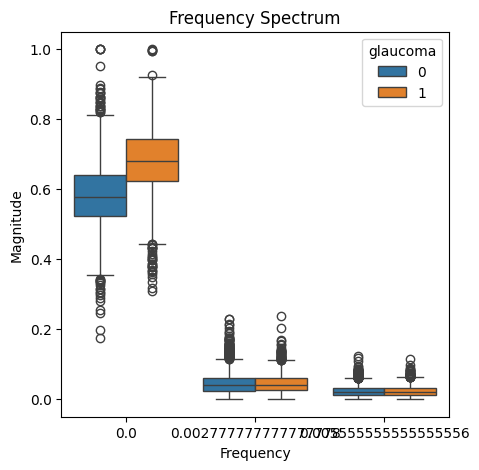

In [ ]:
# Keep magnitudes for first three and last two harmonics
train_fft = train_fft[train_fft['frequency'].isin([freq[idx] for idx in [0, 1, 2]])]

# Scatter plot
plt.figure(figsize=(5, 5))
sns.boxplot(data=train_fft, x='frequency', y='magnitude', hue='glaucoma')
plt.title('Frequency Spectrum')
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.show()

## Wavelet Analysis

In [ ]:
pywt.wavelist(family=None, kind='continuous')

0.0005995205521951111 1.8314923874125244


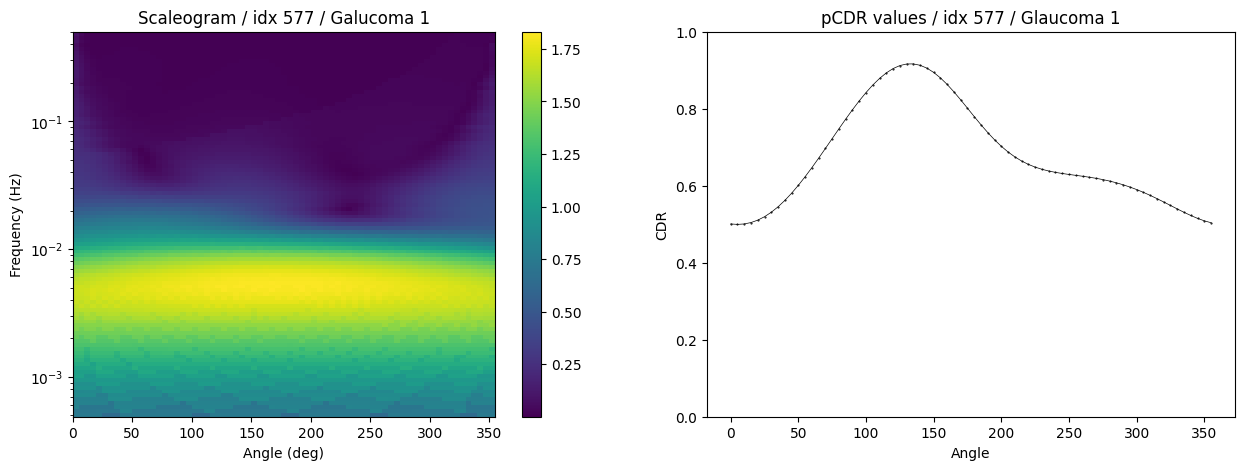

In [914]:
# Continuous wavelet transform of pCDR values
wavelet = 'cmor1.5-0.5'
time = np.arange(0, 360, delta_ang)
# Log scale for scales, as suggested by Torrence & Compo
widths = np.geomspace(1, 1024, num=100)
idx = np.random.choice(train.shape[0], 1)
for i in idx: # [2718] range(train.shape[0]):
    data = train.iloc[i, 2:]
    cwtmatr, freqs = pywt.cwt(data, widths, wavelet)
    # Take absolute value of complex result
    cwtmatr = np.abs(cwtmatr[:-1, :-1])
    # Print range of values
    print(cwtmatr.min(), cwtmatr.max())

# plot result using matplotlib's pcolormesh
fig = plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
pcm = plt.pcolormesh(time, freqs, cwtmatr)
plt.yscale('log')
plt.xlabel("Angle (deg)")
plt.ylabel("Frequency (Hz)")
plt.title(f"Scaleogram / idx {i} / Galucoma {train.iloc[i, 1]}")
plt.colorbar(pcm, ax=plt.gca(), orientation='vertical')
# plt.clim(0, 1)

plt.subplot(1, 2, 2)
plt.plot(np.arange(0, 360, delta_ang), data, 'k.-', linewidth=0.5, markersize=1)
plt.title(f'pCDR values / idx {i} / Glaucoma {train.iloc[i, 1]}')
plt.xlabel('Angle')
plt.ylabel('CDR')
plt.ylim(0, 1)

plt.show()


## Mahalanobis

In [ ]:
# Define method to calculate Mahalanobis distance
def mahalanobis(x, mu, cov):
    """
    Calculate Mahalanobis distance between two vectors x and mu using covariance matrix cov.
    
    Parameters
    ----------
    x : (N,M) array_like
        Input array.
    mu : (N,) array_like
        Mean vector of the distribution.
    cov : (N,N) array_like
        Covariance matrix of the distribution.
        
    """
    
    inv_cov = np.linalg.inv(cov)
    delta = x - mu
    # m = np.dot(np.dot(delta, inv_cov), delta.T)
    m = delta @ inv_cov @ delta.T
    out = np.sqrt(m.diagonal())
    return out

# Calculate Mahalanobis distance for each group
cov_matrices = {}
mean_vectors = {}
for name, group in df_grouped:
    # Covariance matrix
    cov = np.cov(group.iloc[:, 2:].values.T)
    # Add covariance matrix to dictionary
    cov_matrices.update({name: cov})
    # Add mean vector to dictionary
    mean_vectors.update({name: np.mean(group.iloc[:, 2:].values, axis=0)})

Prior probability of glaucoma: 0.3693524096385542
Log prior odds: -0.5349959846938038
#############################################


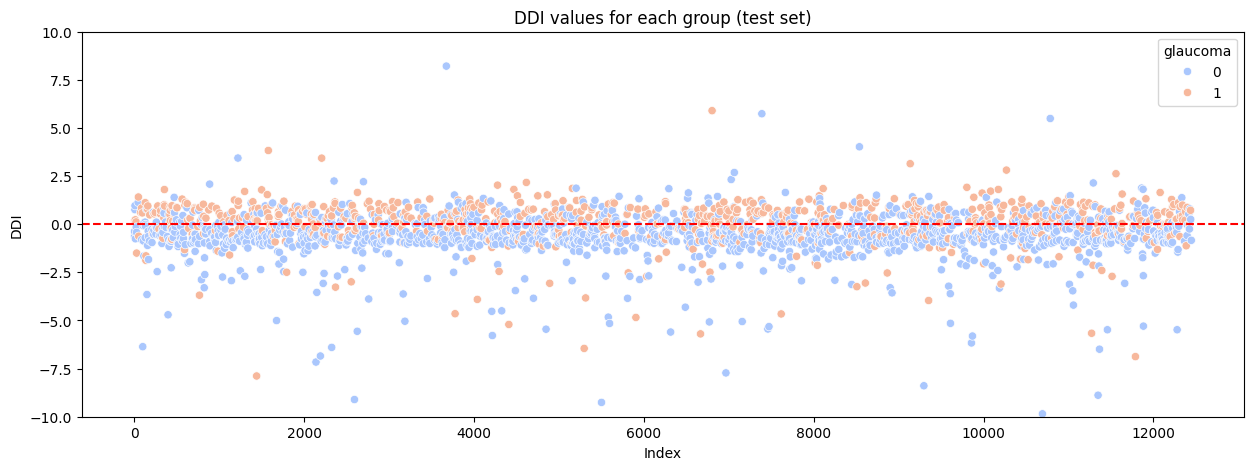

In [ ]:
# Calculate Mahalanobis distance on test for each group
test2 = pd.DataFrame(index=test.index)
for k, v in cov_matrices.items():
    mu = mean_vectors.get(k)
    x = test.iloc[:, 2:].values
    # Add Mahalanobis distance to test2
    col_name = f'mahalanobis_{k}'
    test2[col_name] = mahalanobis(x=x, mu=mu, cov=v)
    
# Prior probability of glaucoma
prior_glaucoma = (train['glaucoma'] == 1).sum() / train.shape[0] # ((train['glaucoma'] == 1).sum() + (train['glaucoma'] == 0).sum())
log_prior_odds = np.log(prior_glaucoma / (1 - prior_glaucoma))
print('Prior probability of glaucoma:', prior_glaucoma)
print(f'Log prior odds: {log_prior_odds}')
print('#############################################')

# log(posterior odds) = log(prior odds) + 0.5 * (mahalanobis_0 - mahalanobis_1)
DDI = test2['mahalanobis_0'] - test2['mahalanobis_1']
# test2['log_posterior_odds'] = log_prior_odds + 0.5 * DDI

# # Posterior probability of glaucoma
# test2['posterior_probability'] = 1 / (1 + np.exp(-test2['log_posterior_odds']))

# # Scatter plot of posterior probability of suspected glaucoma
# plt.figure(figsize=(15, 5))
# sns.scatterplot(x=test2.index, y=test2['posterior_probability'], hue=test['glaucoma'], palette='coolwarm')
# plt.ylim(0, 1)
# plt.xlabel('Index')
# plt.ylabel('Probability of glaucoma')
# plt.title('Posterior probability of patients (test set)')

# Plot DDI values for each group
plt.figure(figsize=(15, 5))
sns.scatterplot(x=test2.index, y=DDI, hue=test['glaucoma'], palette='coolwarm')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Index')
plt.ylabel('DDI')
plt.title('DDI values for each group (test set)')
plt.ylim(-10, 10)
plt.show()

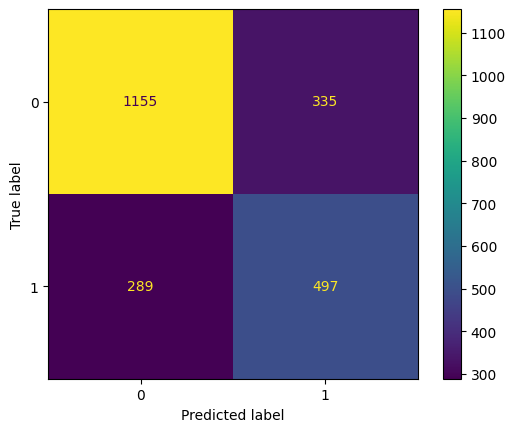

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

# Add DDI to test
test2['DDI'] = DDI

# Classification based on DDI
threshold = 0
test2['predicted_glaucoma'] = np.where(test2['DDI'] > threshold, 1, 0)

# Confusion matrix
y_true = test['glaucoma']
y_pred = test2['predicted_glaucoma']
ConfusionMatrixDisplay.from_predictions(y_true, y_pred)

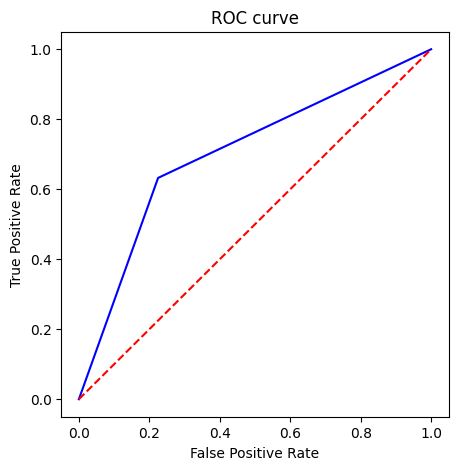

In [ ]:
# Plot ROC curve
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_true, y_pred)
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, 'b')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()

# LME (Linear Mixed Effects) modelling

In [ ]:
# Create a dataframe with column names ['filename', 'glaucoma', 'angle', 'pcdr']
train_mdl = pd.DataFrame(columns=['filename', 'glaucoma', 'angle', 'pcdr'])

# Initialize a list to collect new rows
new_rows = []

for i, row in train.iterrows():
    # Get filename and glaucoma status
    filename = row['filename']
    glaucoma = row['glaucoma']
    # Iterate over each angle
    for id, col in enumerate(train.columns[2:]):
        angle = int(col.split('_')[1])
        pcdr = row[col]
        # Add data to the list of new rows
        new_rows.append({'filename': filename, 'glaucoma': glaucoma, 'angle': angle, 
                         'd':angle/5 + 1, 'd_id': id, 
                         'pcdr': pcdr}) 

# Create a new DataFrame from the list of new rows
train_mdl = pd.DataFrame(new_rows)
        
train_mdl

,filename,glaucoma,angle,d,d_id,pcdr
0,OIA-ODIR-TEST-OFFLINE-256.png,0,0,1.0,0,0.479370
1,OIA-ODIR-TEST-OFFLINE-256.png,0,10,3.0,1,0.476874
2,OIA-ODIR-TEST-OFFLINE-256.png,0,20,5.0,2,0.478466
3,OIA-ODIR-TEST-OFFLINE-256.png,0,30,7.0,3,0.484110
4,OIA-ODIR-TEST-OFFLINE-256.png,0,40,9.0,4,0.493763
...,...,...,...,...,...,...
191227,G1020-931.png,0,310,63.0,31,0.604497
191228,G1020-931.png,0,320,65.0,32,0.587857
191229,G1020-931.png,0,330,67.0,33,0.573541
191230,G1020-931.png,0,340,69.0,34,0.561880


In [ ]:
formula = f'pcdr ~ 1 + np.sin(2*np.pi*d/{360/delta_ang}) + np.cos(2*np.pi*d/{360/delta_ang}) + np.sin(4*np.pi*d/{360/delta_ang}) + np.cos(4*np.pi*d/{360/delta_ang})'

# Mixed LM model
model = smf.mixedlm(formula, train_mdl, groups=train_mdl['glaucoma'],)
                    # re_formula='1', vc_formula={'glaucoma:d_id': '0 + C(d_id)'})

# Fit the model
result = model.fit()

# Print the summary
print(result.summary())

                 Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      pcdr       
No. Observations:      191232       Method:                  REML       
No. Groups:            2            Scale:                   0.0154     
Min. group size:       70632        Log-Likelihood:          127551.7237
Max. group size:       120600       Converged:               Yes        
Mean group size:       95616.0                                          
------------------------------------------------------------------------
                             Coef.  Std.Err.    z    P>|z| [0.025 0.975]
------------------------------------------------------------------------
Intercept                     0.629    0.088   7.169 0.000  0.457  0.802
np.sin(2 * np.pi * d / 72.0)  0.003    0.000   6.502 0.000  0.002  0.003
np.cos(2 * np.pi * d / 72.0) -0.030    0.000 -74.623 0.000 -0.031 -0.029
np.sin(4 * np.pi * d / 72.0) -0.007    0.000 -18.229 0.000 -0.008 -0.

/home/borja/anaconda3/envs/superrempe/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
